# Playground Notebook For Quantizing VLP Models

In [ ]:
# Suppress specific warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# General imports
import os
import torch
import torch.quantization
import pytorch_lightning as pl
from copy import deepcopy
import random
random.seed(42)

# Model Specific imports
from vilt.datamodules.multitask_datamodule import MTDataModule as MTDataModuleVILT
from meter.datamodules.multitask_datamodule import MTDataModule as MTDataModuleMeter
from vilt.modules import ViLTransformerSS
from meter.modules import METERTransformerSS

# Custom imports
import configs
from quantization_utils import get_quantization_config
from quantization_utils import  SmallMTDataModuleMETER, SmallMTDataModuleVILT


/home/mileriso/envs/.py10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Configurations

In [2]:
# Set the configuration
_config = configs.meter_config_nlvr2_original
_config["batch_size"] = 2
_config["per_gpu_batchsize"] = 2

# Set the PyTorch Lightning seed
pl.seed_everything(_config["seed"])

# Limit the number of CPUs
os.environ["OMP_NUM_THREADS"] = "8"  # Set this to the number of CPUs you want to use
os.environ["MKL_NUM_THREADS"] = "8"  # Set this to the number of CPUs you want to use

# Set environment variables
os.environ['MASTER_ADDR'] = 'localhost'
os.environ['MASTER_PORT'] = '12355'

Seed set to 0


## Initialize Distributed Backend

In [3]:
# import torch.distributed as dist
# # Initialize the process group
# dist.init_process_group(backend='gloo', init_method='env://', world_size=1, rank=0)

# # Verify initialization
# print(f"Initialized: {dist.is_initialized()}")

## Define helper functions

In [4]:
def print_size_of_model(model):
    """
    Function to print the size of the model.

    Args:
        model (torch.nn.Module): The model to get the size
    
    Returns:
        None
    """
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')

# Initialize the Datamodule

In [5]:
# ==========================================
# ========= Create full datamodule =========
# ==========================================
if "meter" in _config["model"]:
    # full_dm = MTDataModuleMeter(_config, dist=False)
    
    test_dm = SmallMTDataModuleMETER(_config, dist=False, percentage=0.01)
    test_dm.setup("test", is_random=True)
    test_dataloader = test_dm.test_dataloader()
    
    fine_tune_dm = SmallMTDataModuleMETER(_config, dist=False, percentage=0.1)
    fine_tune_dm.setup("test", is_random=True)
    fine_tune_dataloader = fine_tune_dm.test_dataloader()

elif "vilt" in _config["model"]:
    # full_dm = MTDataModuleVILT(_config, dist=False)

    test_dm = SmallMTDataModuleVILT(_config, dist=False, num_samples=50)
    test_dm.setup("test", is_random=True)
    test_dataloader = test_dm.test_dataloader()

    fine_tune_dm = SmallMTDataModuleVILT(_config, dist=False, num_samples=50)
    fine_tune_dm.setup("test", is_random=True)
    fine_tune_dataloader = fine_tune_dm.test_dataloader()

else:
    raise ValueError("Model not supported: ", _config["model"])

print(f"Batch size: {_config['batch_size']}")
print(f"Lenght of the dataloader: {len(fine_tune_dataloader)}")
print(f"Length of calibration dataloader: {len(test_dataloader)}")

Loaded names: ['nlvr2_train']
Loaded names: ['nlvr2_dev', 'nlvr2_test1']
Loaded names: ['nlvr2_dev', 'nlvr2_test1']
Loaded names: ['nlvr2_train']
Loaded names: ['nlvr2_dev', 'nlvr2_test1']
Loaded names: ['nlvr2_dev', 'nlvr2_test1']
Batch size: 2
Lenght of the dataloader: 697
Length of calibration dataloader: 70


# Initialize The Model

In [6]:
if _config["model"] == "vilt":
    model = ViLTransformerSS(_config)
    print("Initialized ViLT model")

elif _config["model"] == "meter":
    model = METERTransformerSS(_config)
    print("Initialized METER model")

else:
    raise ValueError("Model not supported: ", _config["model"])

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Initialized METER model


# Initialize The Trainer

In [7]:
# ========== Initialize the trainer for full precision ==========
def init_trainer(_config):
    exp_name = f'{_config["exp_name"]}'

    os.makedirs(_config["log_dir"], exist_ok=True)
    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        save_top_k=1,
        verbose=True,
        monitor="val/the_metric",
        mode="max",
        save_last=True,
    )
    logger = pl.loggers.TensorBoardLogger(
        _config["log_dir"],
        name=f'{exp_name}_seed{_config["seed"]}_from_{_config["load_path"].split("/")[-1][:-5]}',
    )

    lr_callback = pl.callbacks.LearningRateMonitor(logging_interval="step")
    callbacks = [checkpoint_callback, lr_callback]

    num_gpus = (
        _config["num_gpus"]
        if isinstance(_config["num_gpus"], int)
        else len(_config["num_gpus"])
    )

    grad_steps = max(_config["batch_size"] // (
        _config["per_gpu_batchsize"] * num_gpus * _config["num_nodes"]
    ), 1)

    max_steps = _config["max_steps"] if _config["max_steps"] is not None else None


    trainer = pl.Trainer(
            accelerator="gpu",
            devices=1,
            num_nodes=_config["num_nodes"],
            precision=_config["precision"],
            # strategy="ddp",
            benchmark=True,
            deterministic=False,
            max_epochs=_config["max_epoch"] if max_steps is None else 1000,
            max_steps=max_steps,
            callbacks=callbacks,
            logger=logger,
            accumulate_grad_batches=grad_steps,
            log_every_n_steps=10,
            fast_dev_run=_config["fast_dev_run"],
            val_check_interval=_config["val_check_interval"],
        )
    
    return trainer

trainer = init_trainer(_config)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


# Dynamic Quantization Functions

In [8]:
def create_quantization_config_dict(bits, module_name_list):
    """
    Creates a dictionary of quantization configurations for specific modules in a model.
    
    Args:
        bits (int): The number of bits to quantize the model to. Available options are 8, 4, and 2.
        module_name_list (list of str): A list of module names (or dot-separated paths) within the model to quantize.
        
    Returns:
        dict: A dictionary of quantization configurations for the specified modules.
    """

    quantization_config, embedding_config = get_quantization_config(bits)
    modules_config = {}

    for module_name in module_name_list:
        if "embedding" in module_name:
            modules_config[module_name] = embedding_config
        else:
            modules_config[module_name] = quantization_config
    
    return modules_config


def quantize_modules(model, bits, module_name_list):
    """
    Quantizes specific modules in a deep copy of the input model using dynamic quantization.

    Args:
        model (torch.nn.Module): The PyTorch model to quantize.
        bits (int): The number of bits to quantize the model to. Available options are 8, 4, and 2.
        module_names_to_quantize (list of str): A list of module names (or dot-separated paths)
                                                 within the model to apply dynamic quantization to.

    Returns:
        torch.nn.Module: A deep copy of the input model with specified modules dynamically quantized.
                         Returns None if no modules are provided to quantize.
    """

    modules_config = create_quantization_config_dict(bits, module_name_list)

    model_quantized = deepcopy(model)
    
    
    torch.quantization.quantize_dynamic(
        model_quantized, modules_config, inplace=True
    )

    return model_quantized

In [9]:
print("Full Precision Model:")
print_size_of_model(model)
print(f"The model is on: {model.device}")

# Quantize the model
bits = 4
modules_to_quantize = [
    "text_transformer.encoder.layer.2.output.dense",
    "text_transformer.encoder.layer.2.intermediate.dense",
    "text_transformer.encoder.layer.3.output.dense",
    "text_transformer.encoder.layer.3.intermediate.dense"
]

model_dynamic = quantize_modules(model, bits, modules_to_quantize)

print(f"Quantized Model ({bits} bits):")
print_size_of_model(model_dynamic)
print(f"The model is on: {model_dynamic.device}")

Full Precision Model:
Size (MB): 1296.258138
The model is on: cpu
Quantized Model (4 bits):
Size (MB): 1267.950002
The model is on: cpu


In [10]:
# example_inputs = next(iter(infer_dataloader))
# print(example_inputs.keys())
# # print(input_["answers"])
# print(f"Number of batches: {len(infer_dataloader)}")
# print(f"Smaples in a batch: {len(example_inputs['answers'])}")

In [11]:
trainer.test(model, test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████| 70/70 [00:08<00:00,  8.24it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   nlvr2/dev/accuracy       0.7850467562675476
nlvr2/dev/accuracy_epoch    0.8055555820465088
     nlvr2/dev/loss         0.5976913571357727
  nlvr2/dev/loss_epoch      0.5927587151527405
   nlvr2/test/accuracy       0.843137264251709
nlvr2/test/accuracy_epoch   0.8208954930305481
     nlvr2/test/loss        0.4164871871471405
  nlvr2/test/loss_epoch     0.4164871871471405
     val/the_metric         0.8208954930305481
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'nlvr2/dev/loss': 0.5976913571357727,
  'nlvr2/dev/accuracy': 0.7850467562675476,
  'nlvr2/test/loss': 0.4164871871471405,
  'nlvr2/test/accuracy': 0.843137264251709,
  'nlvr2/dev/accuracy_epoch': 0.8055555820465088,
  'nlvr2/dev/loss_epoch': 0.5927587151527405,
  'nlvr2/test/accuracy_epoch': 0.8208954930305481,
  'nlvr2/test/loss_epoch': 0.4164871871471405,
  'val/the_metric': 0.8208954930305481}]

# QAT

In [12]:
def print_frozen_layers(model):
    """
    Prints the names of the layers in a PyTorch model and whether they are frozen or not.
    
    Args:
        model (nn.Module): The PyTorch model to print the frozen status of.
    """

    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"Layer: {name}, Frozen: {not param.requires_grad}")


def freeze_except_layers(model, layers_to_unfreeze_names):
    """
    Freezes all parameters of a PyTorch model except for the layers specified by their names.

    Args:
        model (nn.Module): The PyTorch model to freeze parameters in.
        layers_to_unfreeze_names (list of str): A list of module names that should NOT be frozen.
                                             Parameters in modules whose names contain these strings will be unfrozen.
    """
    for name, param in model.named_parameters():
        freeze = True  # Initially assume we should freeze the parameter
        for layer_name_to_unfreeze in layers_to_unfreeze_names:
            if layer_name_to_unfreeze in name:
                freeze = False  # Unfreeze if the name contains a layer to unfreeze
                break  # No need to check other layer names if already unfrozen

        if freeze:
            param.requires_grad = False  # Freeze the parameter
        else:
            param.requires_grad = True   # Ensure it's unfrozen (explicitly set to True)

    # Optional: Print which layers are frozen and unfrozen for verification
    print_frozen_layers(model)
    

In [14]:
from torch.ao.quantization.qconfig import default_dynamic_qat_qconfig
from torch.ao.quantization.quantize import convert, propagate_qconfig_, prepare
from torch.ao.quantization.quantization_mappings import get_default_qat_module_mappings
import copy

def prepare_qat(model, qconfig_dict, mapping=None, inplace=False):
    r"""
    Prepares a copy of the model for quantization calibration or
    quantization-aware training and converts it to quantized version.

    Quantization configuration should be assigned preemptively
    to individual submodules in `.qconfig` attribute.

    Args:
        model: input model to be modified in-place
        mapping: dictionary that maps float modules to quantized modules to be
                 replaced.
        inplace: carry out model transformations in-place, the original module
                 is mutated
    """
    torch._C._log_api_usage_once("quantization_api.quantize.prepare_qat")
    assert model.training, "prepare_qat only works on models in training mode"
    if mapping is None:
        mapping = get_default_qat_module_mappings()

    if not inplace:
        model = copy.deepcopy(model)

    propagate_qconfig_(model, qconfig_dict=qconfig_dict)
    convert(model, mapping=mapping, inplace=True, remove_qconfig=False)
    prepare(model, observer_non_leaf_module_list=set(mapping.values()), inplace=True)
    return model


# Create the quantization configuration dictionary
qconfig_dict = dict()
for layer in modules_to_quantize:
    qconfig_dict[layer] = default_dynamic_qat_qconfig

# Prepare the model for quantization-aware training
model_qat = prepare_qat(model, inplace=False, qconfig_dict=qconfig_dict)

# Freeze all layers except for the quantized layers
freeze_except_layers(model_qat, modules_to_quantize)

Layer: text_transformer.encoder.layer.2.intermediate.dense.weight, Frozen: False
Layer: text_transformer.encoder.layer.2.intermediate.dense.bias, Frozen: False
Layer: text_transformer.encoder.layer.2.output.dense.weight, Frozen: False
Layer: text_transformer.encoder.layer.2.output.dense.bias, Frozen: False
Layer: text_transformer.encoder.layer.3.intermediate.dense.weight, Frozen: False
Layer: text_transformer.encoder.layer.3.intermediate.dense.bias, Frozen: False
Layer: text_transformer.encoder.layer.3.output.dense.weight, Frozen: False
Layer: text_transformer.encoder.layer.3.output.dense.bias, Frozen: False


In [15]:
# Count the trainable parameters
sum_param = 0
for name, param in model_qat.named_parameters():
    if param.requires_grad:
        print(name, param.numel())
        sum_param += param.numel()
    
print(f"Total trainable parameters: {sum_param}")

text_transformer.encoder.layer.2.intermediate.dense.weight 2359296
text_transformer.encoder.layer.2.intermediate.dense.bias 3072
text_transformer.encoder.layer.2.output.dense.weight 2359296
text_transformer.encoder.layer.2.output.dense.bias 768
text_transformer.encoder.layer.3.intermediate.dense.weight 2359296
text_transformer.encoder.layer.3.intermediate.dense.bias 3072
text_transformer.encoder.layer.3.output.dense.weight 2359296
text_transformer.encoder.layer.3.output.dense.bias 768
Total trainable parameters: 9444864


In [16]:
trainer.fit(model_qat, test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name                        | Type         | Params | Mode 
----------------------------------------------------------------------
0  | cross_modal_text_transform  | Linear       | 590 K  | train
1  | cross_modal_image_transform | Linear       | 590 K  | train
2  | token_type_embeddings       | Embedding    | 2.3 K  | train
3  | vit_model                   | CLIP         | 78.9 M | train
4  | text_transformer            | RobertaModel | 124 M  | eval 
5  | cross_modal_image_layers    | ModuleList   | 56.7 M | train
6  | cross_modal_text_layers     | ModuleList   | 56.7 M | train
7  | cross_modal_image_pooler    | Pooler       | 590 K  | train
8  | cross_modal_text_pooler     | Pooler       | 590 K  | train
9  | nlvr2_classifier            | Sequential   | 4.7 M  | train
10 | train_nlvr2_accuracy        | Accuracy     | 0      | train
11 | train_nlvr2_loss            | Scalar       | 0      | train
12 | dev_nlvr2_accuracy          | Accu

Epoch 0:   0%|          | 0/70 [00:00<?, ?it/s] Executing training_step for task ['nlvr2']
Output is obtained: dict_keys(['nlvr2_loss', 'nlvr2_logits', 'nlvr2_labels'])
Total loss is 0.0025637000799179077
Epoch 0:   1%|▏         | 1/70 [00:00<00:56,  1.23it/s, v_num=8]

Epoch 0, global step 1: 'val/the_metric' was not in top 1
`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 0:   1%|▏         | 1/70 [00:06<07:28,  0.15it/s, v_num=8]


In [17]:
# Count the trainable parameters
sum_param = 0
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.numel())
        sum_param += param.numel()
    
print(f"Total trainable parameters: {sum_param}")

cross_modal_text_transform.weight 589824
cross_modal_text_transform.bias 768
cross_modal_image_transform.weight 589824
cross_modal_image_transform.bias 768
token_type_embeddings.weight 2304
vit_model.positional_embedding 39424
vit_model.visual.class_embedding 768
vit_model.visual.positional_embedding 249600
vit_model.visual.conv1.weight 589824
vit_model.visual.ln_pre.weight 768
vit_model.visual.ln_pre.bias 768
vit_model.visual.transformer.resblocks.0.attn.in_proj_weight 1769472
vit_model.visual.transformer.resblocks.0.attn.in_proj_bias 2304
vit_model.visual.transformer.resblocks.0.attn.out_proj.weight 589824
vit_model.visual.transformer.resblocks.0.attn.out_proj.bias 768
vit_model.visual.transformer.resblocks.0.ln_1.weight 768
vit_model.visual.transformer.resblocks.0.ln_1.bias 768
vit_model.visual.transformer.resblocks.0.mlp.c_fc.weight 2359296
vit_model.visual.transformer.resblocks.0.mlp.c_fc.bias 3072
vit_model.visual.transformer.resblocks.0.mlp.c_proj.weight 2359296
vit_model.visual

In [18]:
trainer = init_trainer(_config)
trainer.fit(model, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name                        | Type         | Params | Mode 
----------------------------------------------------------------------
0  | cross_modal_text_transform  | Linear       | 590 K  | train
1  | cross_modal_image_transform | Linear       | 590 K  | train
2  | token_type_embeddings       | Embedding    | 2.3 K  | train
3  | vit_model                   | CLIP         | 78.9 M | train
4  | text_transformer            | RobertaModel | 124 M  | eval 
5  | cross_modal_image_layers    | ModuleList   | 56.7 M | train
6  | cross_modal_text_layers     | ModuleList   | 56.7 M | train
7  | cross_modal_image_pooler    | Pooler       | 590 K  | train
8  | cross_modal_text_pooler     | Pooler       | 590 K  | train
9  | nlvr2_

Epoch 0:   0%|          | 0/70 [00:00<?, ?it/s] Executing training_step for task ['nlvr2']
Output is obtained: dict_keys(['nlvr2_loss', 'nlvr2_logits', 'nlvr2_labels'])
Total loss is 0.0018258416093885899
Epoch 0:   1%|▏         | 1/70 [00:00<01:05,  1.06it/s, v_num=9]

Epoch 0, global step 1: 'val/the_metric' was not in top 1


OSError: [Errno 28] No space left on device: '/tmp/tmph4ubnmdl' -> '/home/mileriso/thesis/result/finetune_nlvr2_seed0_from_meter_nlvr2/version_9/checkpoints/last.ckpt'

In [ ]:
convert(model_qat, inplace=True)

METERTransformerSS(
  (cross_modal_text_transform): Linear(in_features=768, out_features=768, bias=True)
  (cross_modal_image_transform): Linear(in_features=768, out_features=768, bias=True)
  (token_type_embeddings): Embedding(3, 768)
  (vit_model): CLIP(
    (visual): VisualTransformer(
      (conv1): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
      (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (transformer): Transformer(
        (resblocks): Sequential(
          (0): ResidualAttentionBlock(
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
            )
            (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (mlp): Sequential(
              (c_fc): Linear(in_features=768, out_features=3072, bias=True)
              (gelu): QuickGELU()
              (c_proj): Linear(in_features=3072, out_features=768, bias=True)
  

In [20]:
trainer.test(model_qat, test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████| 70/70 [00:09<00:00,  7.75it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   nlvr2/dev/accuracy       0.7943925261497498
nlvr2/dev/accuracy_epoch    0.8194444179534912
     nlvr2/dev/loss         0.5969018340110779
  nlvr2/dev/loss_epoch      0.5920029282569885
   nlvr2/test/accuracy       0.843137264251709
nlvr2/test/accuracy_epoch   0.8208954930305481
     nlvr2/test/loss        0.4254521429538727
  nlvr2/test/loss_epoch     0.4254521429538727
     val/the_metric         0.8208954930305481
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'nlvr2/dev/loss': 0.5969018340110779,
  'nlvr2/dev/accuracy': 0.7943925261497498,
  'nlvr2/test/loss': 0.4254521429538727,
  'nlvr2/test/accuracy': 0.843137264251709,
  'nlvr2/dev/accuracy_epoch': 0.8194444179534912,
  'nlvr2/dev/loss_epoch': 0.5920029282569885,
  'nlvr2/test/accuracy_epoch': 0.8208954930305481,
  'nlvr2/test/loss_epoch': 0.4254521429538727,
  'val/the_metric': 0.8208954930305481}]

In [21]:
trainer.test(model_dynamic, test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0:   0%|          | 0/70 [00:00<?, ?it/s]

NotImplementedError: Could not run 'quantized::linear_dynamic' with arguments from the 'CUDA' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'quantized::linear_dynamic' is only available for these backends: [CPU, Meta, BackendSelect, Python, FuncTorchDynamicLayerBackMode, Functionalize, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradXLA, AutogradMPS, AutogradXPU, AutogradHPU, AutogradLazy, AutogradMeta, Tracer, AutocastCPU, AutocastXPU, AutocastMPS, AutocastCUDA, FuncTorchBatched, BatchedNestedTensor, FuncTorchVmapMode, Batched, VmapMode, FuncTorchGradWrapper, PythonTLSSnapshot, FuncTorchDynamicLayerFrontMode, PreDispatch, PythonDispatcher].

CPU: registered at ../aten/src/ATen/native/quantized/cpu/qlinear_dynamic.cpp:791 [kernel]
Meta: registered at ../aten/src/ATen/core/MetaFallbackKernel.cpp:23 [backend fallback]
BackendSelect: fallthrough registered at ../aten/src/ATen/core/BackendSelectFallbackKernel.cpp:3 [backend fallback]
Python: registered at ../aten/src/ATen/core/PythonFallbackKernel.cpp:153 [backend fallback]
FuncTorchDynamicLayerBackMode: registered at ../aten/src/ATen/functorch/DynamicLayer.cpp:497 [backend fallback]
Functionalize: registered at ../aten/src/ATen/FunctionalizeFallbackKernel.cpp:349 [backend fallback]
Named: registered at ../aten/src/ATen/core/NamedRegistrations.cpp:7 [backend fallback]
Conjugate: registered at ../aten/src/ATen/ConjugateFallback.cpp:17 [backend fallback]
Negative: registered at ../aten/src/ATen/native/NegateFallback.cpp:18 [backend fallback]
ZeroTensor: registered at ../aten/src/ATen/ZeroTensorFallback.cpp:86 [backend fallback]
ADInplaceOrView: fallthrough registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:96 [backend fallback]
AutogradOther: registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:63 [backend fallback]
AutogradCPU: registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:67 [backend fallback]
AutogradCUDA: registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:75 [backend fallback]
AutogradXLA: registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:79 [backend fallback]
AutogradMPS: registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:87 [backend fallback]
AutogradXPU: registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:71 [backend fallback]
AutogradHPU: registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:100 [backend fallback]
AutogradLazy: registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:83 [backend fallback]
AutogradMeta: registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:91 [backend fallback]
Tracer: registered at ../torch/csrc/autograd/TraceTypeManual.cpp:294 [backend fallback]
AutocastCPU: fallthrough registered at ../aten/src/ATen/autocast_mode.cpp:321 [backend fallback]
AutocastXPU: fallthrough registered at ../aten/src/ATen/autocast_mode.cpp:463 [backend fallback]
AutocastMPS: fallthrough registered at ../aten/src/ATen/autocast_mode.cpp:209 [backend fallback]
AutocastCUDA: fallthrough registered at ../aten/src/ATen/autocast_mode.cpp:165 [backend fallback]
FuncTorchBatched: registered at ../aten/src/ATen/functorch/LegacyBatchingRegistrations.cpp:731 [backend fallback]
BatchedNestedTensor: registered at ../aten/src/ATen/functorch/LegacyBatchingRegistrations.cpp:758 [backend fallback]
FuncTorchVmapMode: fallthrough registered at ../aten/src/ATen/functorch/VmapModeRegistrations.cpp:27 [backend fallback]
Batched: registered at ../aten/src/ATen/LegacyBatchingRegistrations.cpp:1075 [backend fallback]
VmapMode: fallthrough registered at ../aten/src/ATen/VmapModeRegistrations.cpp:33 [backend fallback]
FuncTorchGradWrapper: registered at ../aten/src/ATen/functorch/TensorWrapper.cpp:207 [backend fallback]
PythonTLSSnapshot: registered at ../aten/src/ATen/core/PythonFallbackKernel.cpp:161 [backend fallback]
FuncTorchDynamicLayerFrontMode: registered at ../aten/src/ATen/functorch/DynamicLayer.cpp:493 [backend fallback]
PreDispatch: registered at ../aten/src/ATen/core/PythonFallbackKernel.cpp:165 [backend fallback]
PythonDispatcher: registered at ../aten/src/ATen/core/PythonFallbackKernel.cpp:157 [backend fallback]


In [22]:
print_frozen_layers(model_qat)

Layer: text_transformer.encoder.layer.2.intermediate.dense.weight, Frozen: False
Layer: text_transformer.encoder.layer.2.intermediate.dense.bias, Frozen: False
Layer: text_transformer.encoder.layer.2.output.dense.weight, Frozen: False
Layer: text_transformer.encoder.layer.2.output.dense.bias, Frozen: False
Layer: text_transformer.encoder.layer.3.intermediate.dense.weight, Frozen: False
Layer: text_transformer.encoder.layer.3.intermediate.dense.bias, Frozen: False
Layer: text_transformer.encoder.layer.3.output.dense.weight, Frozen: False
Layer: text_transformer.encoder.layer.3.output.dense.bias, Frozen: False


# Quantization | PTQ to 8-bits

## Dynamic Quantization Analysis

In [ ]:
bit8_linear, bit8_embedding = get_quantization_config(8)
bit4_linear, bit4_embedding = get_quantization_config(4)
bit2_linear, bit2_embedding = get_quantization_config(2)
bit1_linear, bit1_embedding = get_quantization_config(1)


print("Full Precision Model:")
print_size_of_model(model)

model_8 = copy.deepcopy(model)
model_4 = copy.deepcopy(model)
model_2 = copy.deepcopy(model)
model_1 = copy.deepcopy(model)

torch.quantization.quantize_dynamic(
    model_8, {torch.nn.Embedding: bit8_embedding}, dtype=torch.quint8, inplace=True
)
torch.quantization.quantize_dynamic(
    model_8, {torch.nn.Linear: bit8_linear, torch.nn.LayerNorm: bit8_linear}, dtype=torch.qint8, inplace=True
)



torch.quantization.quantize_dynamic(
    model_4, {torch.nn.Embedding: bit4_embedding}, dtype=torch.quint8, inplace=True
)
torch.quantization.quantize_dynamic(
    model_4, {torch.nn.Linear: bit4_linear, torch.nn.LayerNorm: bit2_linear}, dtype=torch.qint8, inplace=True
)



torch.quantization.quantize_dynamic(
    model_2, {torch.nn.Embedding: bit2_embedding}, dtype=torch.quint8, inplace=True
)
torch.quantization.quantize_dynamic(
    model_2, {torch.nn.Linear: bit2_linear, torch.nn.LayerNorm: bit2_linear}, dtype=torch.qint8, inplace=True
)



torch.quantization.quantize_dynamic(
    model_1, {torch.nn.Embedding: bit1_embedding}, dtype=torch.quint8, inplace=True
)
torch.quantization.quantize_dynamic(
    model_1, {torch.nn.Linear: bit1_linear, torch.nn.LayerNorm: bit1_linear}, dtype=torch.qint8, inplace=True
)



print("Fully Quantized Model:")
print_size_of_model(model_8)

# print(f"Quantized Model with only the {layer_to_quantize} layer:")
# print_size_of_model(_model_)

Full Precision Model:
Size of the model (MB): 455.900978
Fully Quantized Model:
Size of the model (MB): 122.099212


In [ ]:
# Function to get the block from the model
def get_block(model, block_selection):
    attrs = block_selection.split('.')
    block = model
    for attr in attrs:
        if '[' in attr and ']' in attr:
            attr_name, index = attr[:-1].split('[')
            block = getattr(block, attr_name)[int(index)]
        else:
            block = getattr(block, attr)
    return block

In [ ]:
# Define the block selection
block_selection = 'transformer.blocks[0].mlp.fc1'

with torch.no_grad():
    # Get the blocks from each model
    block_full_precision = get_block(model, block_selection)
    block_8bit = get_block(model_8, block_selection)
    block_4bit = get_block(model_4, block_selection)
    block_2bit = get_block(model_2, block_selection)

    # Dequantize the quantized weights before performing the operation
    weight_full_precision = block_full_precision.weight
    weight_8bit = block_8bit.weight().dequantize()  # Dequantize 8-bit weights
    weight_4bit = block_4bit.weight().dequantize()  # Dequantize 4-bit weights
    weight_2bit = block_2bit.weight().dequantize()  # Dequantize 2-bit weights

    # Compute relative changes
    relative_change_8bit = torch.abs(weight_full_precision - weight_8bit) / torch.abs(weight_full_precision)
    relative_change_4bit = torch.abs(weight_full_precision - weight_4bit) / torch.abs(weight_full_precision)
    relative_change_2bit = torch.abs(weight_full_precision - weight_2bit) / torch.abs(weight_full_precision)

    # Handle division by zero (if any original weight is zero)
    relative_change_8bit[torch.isnan(relative_change_8bit)] = 0  # Set NaN to 0
    relative_change_4bit[torch.isnan(relative_change_4bit)] = 0  # Set NaN to 0
    relative_change_2bit[torch.isnan(relative_change_2bit)] = 0  # Set NaN to 0

    # Convert to percentage (optional)
    relative_change_8bit_percent = relative_change_8bit * 100
    relative_change_4bit_percent = relative_change_4bit * 100
    relative_change_2bit_percent = relative_change_2bit * 100

    # Print statistics
    print("8-bit Relative Change (Mean):", torch.mean(relative_change_8bit).item())
    print("4-bit Relative Change (Mean):", torch.mean(relative_change_4bit).item())
    print("2-bit Relative Change (Mean):", torch.mean(relative_change_2bit).item())

    print("8-bit Relative Change (Max):", torch.max(relative_change_8bit).item())
    print("4-bit Relative Change (Max):", torch.max(relative_change_4bit).item())
    print("2-bit Relative Change (Max):", torch.max(relative_change_2bit).item())

    print("8-bit Relative Change Percentage (Mean):", torch.mean(relative_change_8bit_percent).item())
    print("4-bit Relative Change Percentage (Mean):", torch.mean(relative_change_4bit_percent).item())
    print("2-bit Relative Change Percentage (Mean):", torch.mean(relative_change_2bit_percent).item())

    # Identify weights with the largest relative changes
    top_k = 10  # Number of top weights to identify
    top_8bit_indices = torch.topk(relative_change_8bit.flatten(), k=top_k).indices
    top_4bit_indices = torch.topk(relative_change_4bit.flatten(), k=top_k).indices
    top_2bit_indices = torch.topk(relative_change_2bit.flatten(), k=top_k).indices

    print("Top 8-bit weights with largest relative changes:", top_8bit_indices)
    print("Top 4-bit weights with largest relative changes:", top_4bit_indices)
    print("Top 2-bit weights with largest relative changes:", top_2bit_indices)

8-bit Relative Change (Mean): 0.1676570475101471
4-bit Relative Change (Mean): 0.925999104976654
2-bit Relative Change (Mean): 0.9999205470085144
8-bit Relative Change (Max): 1.0
4-bit Relative Change (Max): 1.0
2-bit Relative Change (Max): 1.0
8-bit Relative Change Percentage (Mean): 16.765705108642578
4-bit Relative Change Percentage (Mean): 92.59990692138672
2-bit Relative Change Percentage (Mean): 99.9920425415039
Top 8-bit weights with largest relative changes: tensor([ 78,  44,  72,  38,  15, 132, 155, 172, 144,  64])
Top 4-bit weights with largest relative changes: tensor([ 8,  9,  4,  3,  5,  1,  0, 10,  2,  6])
Top 2-bit weights with largest relative changes: tensor([8, 9, 4, 7, 5, 3, 1, 0, 2, 6])


In [30]:
# Define the block selection
block_selection = 'transformer.blocks[0].mlp.fc1'
with torch.no_grad():
    # Get the blocks from each model
    block_full_precision = get_block(model, block_selection)
    block_8bit = get_block(model_8, block_selection)
    block_4bit = get_block(model_4, block_selection)
    block_2bit = get_block(model_2, block_selection)

    # Dequantize the quantized weights before performing the operation
    weight_full_precision = block_full_precision.weight
    weight_8bit = block_8bit.weight().dequantize() # .int_repr().float()
    weight_4bit = block_4bit.weight().dequantize() # .int_repr().float()
    weight_2bit = block_2bit.weight().dequantize() # .int_repr().float()

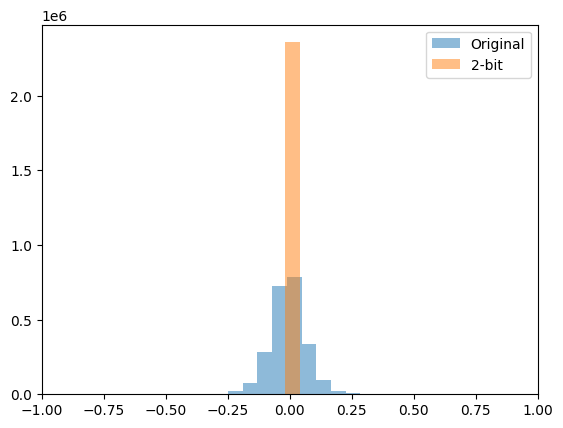

KL Divergence: 0.006750397456343222
KL Divergence: 17.704822635573848
KL Divergence: 24.204427696510965


In [36]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy

# Example: Plot histograms
plt.hist(weight_full_precision.flatten().detach().numpy(), bins=50, alpha=0.5, label="Original")
# plt.hist(weight_8bit.flatten().detach().numpy(), bins=50, alpha=0.5, label="8-bit")
# plt.hist(weight_4bit.flatten().detach().numpy(), bins=50, alpha=0.5, label="4-bit")
plt.hist(weight_2bit.flatten().detach().numpy(), bins=50, alpha=0.5, label="2-bit")
plt.legend()
plt.xlim(-1, 1)
plt.show()

def compute_kl_divergence(original, quantized, bins=50, epsilon=1e-10):
    hist_original, _ = np.histogram(original, bins=bins, density=True)
    hist_quantized, _ = np.histogram(quantized, bins=bins, density=True)
    
    # Add epsilon to avoid zero probabilities
    hist_original = hist_original + epsilon
    hist_quantized = hist_quantized + epsilon
    
    # Normalize to ensure valid probability distributions
    hist_original = hist_original / np.sum(hist_original)
    hist_quantized = hist_quantized / np.sum(hist_quantized)
    
    return entropy(hist_original, hist_quantized)

kl_divergence = compute_kl_divergence(weight_full_precision.flatten().detach().numpy(), weight_8bit.flatten().detach().numpy())
print("KL Divergence:", kl_divergence)

kl_divergence = compute_kl_divergence(weight_full_precision.flatten().detach().numpy(), weight_4bit.flatten().detach().numpy())
print("KL Divergence:", kl_divergence)

kl_divergence = compute_kl_divergence(weight_full_precision.flatten().detach().numpy(), weight_2bit.flatten().detach().numpy())
print("KL Divergence:", kl_divergence)

In [16]:
print(f"Max value of the first layer of the transformer blocks:")
print(weight_full_precision.max().item())
print()

print(f"Min value of the first layer of the transformer blocks:")
print(weight_full_precision.min().item())
print()

print(f"Average of the first layer of the transformer blocks:")
print(weight_full_precision.mean().item())

Max value of the first layer of the transformer blocks:
2.4307639598846436

Min value of the first layer of the transformer blocks:
-3.06199312210083

Average of the first layer of the transformer blocks:
3.992090205429122e-05


In [22]:
print(f"Max value of the first layer of the transformer blocks:")
print(weight_8bit.max().item())
print()

print(f"Min value of the first layer of the transformer blocks:")
print(weight_8bit.min().item())
print()

print(f"Average of the first layer of the transformer blocks:")
print(weight_8bit.mean().item())
print()

print(f"Average difference between 8-bit version and full precision:")
print(torch.abs(block_8bit.weight().dequantize() - weight_full_precision).mean().item())

Max value of the first layer of the transformer blocks:
2.4255788326263428

Min value of the first layer of the transformer blocks:
-3.074000835418701

Average of the first layer of the transformer blocks:
3.338760870974511e-05

Average difference between 8-bit version and full precision:
0.005997746717184782


In [21]:
print(f"Max value of the first layer of the transformer blocks:")
print(weight_4bit.max().item())
print()

print(f"Min value of the first layer of the transformer blocks:")
print(weight_4bit.min().item())
print()

print(f"Average of the first layer of the transformer blocks:")
print(weight_4bit.mean().item())
print()

print(f"Average difference between 4-bit version and full precision:")
print(torch.abs(weight_4bit - weight_full_precision).mean().item())
print()

print(f"Average difference between 4-bit version and 8-bit version:")
print(torch.abs(weight_4bit - weight_8bit).mean().item())

Max value of the first layer of the transformer blocks:
2.449594497680664

Min value of the first layer of the transformer blocks:
-3.2661259174346924

Average of the first layer of the transformer blocks:
1.4881919923936948e-05

Average difference between 4-bit version and full precision:
0.04256489500403404

Average difference between 4-bit version and 8-bit version:
0.042156487703323364


In [20]:
print(f"Max value of the first layer of the transformer blocks:")
print(weight_2bit.max().item())
print()

print(f"Min value of the first layer of the transformer blocks:")
print(weight_2bit.min().item())
print()

print(f"Average of the first layer of the transformer blocks:")
print(weight_2bit.mean().item())
print()

print(f"Average difference between 2-bit version and full precision:")
print(torch.abs(weight_2bit - weight_full_precision).mean().item())
print()

print(f"Average difference between 2-bit version and 8-bit version:")
print(torch.abs(weight_2bit - weight_8bit).mean().item())
print()

print(f"Average difference between 2-bit version and 4-bit version:")
print(torch.abs(weight_2bit - weight_4bit).mean().item())

Max value of the first layer of the transformer blocks:
2.0413286685943604

Min value of the first layer of the transformer blocks:
-4.082657337188721

Average of the first layer of the transformer blocks:
-1.7304555512964725e-06

Average difference between 2-bit version and full precision:
0.0428580567240715

Average difference between 2-bit version and 8-bit version:
0.042456429451704025

Average difference between 2-bit version and 4-bit version:
0.001149368821643293


In [24]:
import dynamic_quantization as dq

default_dynamic = copy.deepcopy(model)

torch.quantization.quantize_dynamic(
        default_dynamic, {torch.nn.Embedding, torch.nn.Conv2d}, dtype=torch.quint8, inplace=True
    )

torch.quantization.quantize_dynamic(
        default_dynamic, {torch.nn.Linear, torch.nn.LayerNorm, torch.nn.Conv2d}, dtype=torch.qint8, inplace=True
    )

print("Size after quantization:")
print_size_of_model(default_dynamic)
print(default_dynamic)

Size after quantization:
Size (MB): 122.099212
ViLTransformerSS(
  (text_embeddings): BertEmbeddings(
    (word_embeddings): QuantizedEmbedding(num_embeddings=30522, embedding_dim=768, dtype=torch.quint8, qscheme=torch.per_channel_affine_float_qparams)
    (position_embeddings): QuantizedEmbedding(num_embeddings=40, embedding_dim=768, dtype=torch.quint8, qscheme=torch.per_channel_affine_float_qparams)
    (token_type_embeddings): QuantizedEmbedding(num_embeddings=2, embedding_dim=768, dtype=torch.quint8, qscheme=torch.per_channel_affine_float_qparams)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (quant): QuantStub()
    (dequant): DeQuantStub()
  )
  (token_type_embeddings): QuantizedEmbedding(num_embeddings=3, embedding_dim=768, dtype=torch.quint8, qscheme=torch.per_channel_affine_float_qparams)
  (transformer): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(32, 32),

In [72]:
import dynamic_quantization as dq

custom_8bit = copy.deepcopy(model)
custom_8bit = dq.quantize_model_dynamic(custom_8bit, 8)

print("Size after quantization:")
print_size_of_model(custom_8bit)
# print(model_dynamic)

======== Quantizing the model DYNAMIC =========
Size after quantization:
Size of the model (MB): 122.099212


# Numeric Suite Analysis

In [73]:
import torch.quantization._numeric_suite as ns

def compute_error(x, y):
    """
    Signal to Noise Ratio (SNR)    
    """
    Ps = torch.norm(x)
    Pn = torch.norm(x-y)
    return 20*torch.log10(Ps/Pn)

## Dynamic Model

In [74]:
# ======== Dynamic quantization comparison ========
wt_compare_dict_dynamic = ns.compare_weights(model.state_dict(), custom_8bit.state_dict())

# print('keys of wt_compare_dict:')
# print(wt_compare_dict_dynamic.keys())

# key = 'text_embeddings.LayerNorm.weight'

total_error = 0
inf_count = 0
max_err = 0
for i, key in enumerate(wt_compare_dict_dynamic):
    if wt_compare_dict_dynamic[key]['quantized'].is_quantized:
        err = compute_error(wt_compare_dict_dynamic[key]['float'], wt_compare_dict_dynamic[key]['quantized'].dequantize())
        
        print(f"{i} - {key}")
        print(f"{i} - {err:.2f}")
        
        if not torch.isinf(err):
            total_error += err
            if err > max_err:
                max_err = err
        else:
            inf_count += 1
    else:
        err = compute_error(wt_compare_dict_dynamic[key]['float'], wt_compare_dict_dynamic[key]['quantized'])
        
        print(f"{i} - {key}")
        print(f"{i} - {err:.2f}")

        if not torch.isinf(err):
            total_error += err
            if err > max_err:
                max_err = err
        else:
            inf_count += 1

print(f"Total error: {total_error:.2f}")
print(f"Total inf: {inf_count}")
print(f"Max error: {max_err}")

0 - text_embeddings.LayerNorm.weight
0 - inf
1 - transformer.patch_embed.proj.weight
1 - inf
2 - transformer.blocks.0.norm1.weight
2 - inf
3 - transformer.blocks.0.attn.qkv._packed_params._packed_params
3 - 27.66
4 - transformer.blocks.0.attn.proj._packed_params._packed_params
4 - 21.96
5 - transformer.blocks.0.norm2.weight
5 - inf
6 - transformer.blocks.0.mlp.fc1._packed_params._packed_params
6 - 26.82
7 - transformer.blocks.0.mlp.fc2._packed_params._packed_params
7 - 18.22
8 - transformer.blocks.1.norm1.weight
8 - inf
9 - transformer.blocks.1.attn.qkv._packed_params._packed_params
9 - 32.16
10 - transformer.blocks.1.attn.proj._packed_params._packed_params
10 - 29.15
11 - transformer.blocks.1.norm2.weight
11 - inf
12 - transformer.blocks.1.mlp.fc1._packed_params._packed_params
12 - 27.63
13 - transformer.blocks.1.mlp.fc2._packed_params._packed_params
13 - 16.82
14 - transformer.blocks.2.norm1.weight
14 - inf
15 - transformer.blocks.2.attn.qkv._packed_params._packed_params
15 - 33.97
1

In [81]:
infer_batch = next(iter(infer_dataloader))
# calibration_batch = next(iter(calibrarte_dm.val_dataloader()))
# full_batch = next(iter(full_dm.val_dataloader()))

In [82]:
# act_compare_dict_dynamic = ns.compare_model_outputs(copy.deepcopy(model), copy.deepcopy(model_dynamic), full_batch)
act_compare_dict_dynamic = ns.compare_model_outputs(copy.deepcopy(model), copy.deepcopy(custom_8bit), infer_batch)
print(act_compare_dict_dynamic.keys())

dict_keys(['text_embeddings.LayerNorm.stats', 'text_embeddings.quant.stats', 'transformer.patch_embed.proj.stats', 'transformer.blocks.0.norm1.stats', 'transformer.blocks.0.attn.qkv.stats', 'transformer.blocks.0.attn.proj.stats', 'transformer.blocks.0.norm2.stats', 'transformer.blocks.0.mlp.fc1.stats', 'transformer.blocks.0.mlp.fc2.stats', 'transformer.blocks.1.norm1.stats', 'transformer.blocks.1.attn.qkv.stats', 'transformer.blocks.1.attn.proj.stats', 'transformer.blocks.1.norm2.stats', 'transformer.blocks.1.mlp.fc1.stats', 'transformer.blocks.1.mlp.fc2.stats', 'transformer.blocks.2.norm1.stats', 'transformer.blocks.2.attn.qkv.stats', 'transformer.blocks.2.attn.proj.stats', 'transformer.blocks.2.norm2.stats', 'transformer.blocks.2.mlp.fc1.stats', 'transformer.blocks.2.mlp.fc2.stats', 'transformer.blocks.3.norm1.stats', 'transformer.blocks.3.attn.qkv.stats', 'transformer.blocks.3.attn.proj.stats', 'transformer.blocks.3.norm2.stats', 'transformer.blocks.3.mlp.fc1.stats', 'transformer.bl

In [83]:
total_err = 0
inf_count = 0
max_err = 0
for idx, key in enumerate(act_compare_dict_dynamic):
    err = compute_error(act_compare_dict_dynamic[key]['float'][0][0], act_compare_dict_dynamic[key]['quantized'][0][0])
    # print(type(err))
    if torch.isinf(err):
        inf_count += 1
    else:
        total_err += err
        if err > max_err:
            max_err = err
    print(f"{idx} - {key}")
    print(f"{idx} - {err:.2f}")

print(f"Total error: {total_err:.2f}")
# print(f"Total inf: {inf_count}")
# print(f"Max error: {max_err}")

0 - text_embeddings.LayerNorm.stats
0 - 38.81
1 - text_embeddings.quant.stats
1 - 38.69
2 - transformer.patch_embed.proj.stats
2 - inf
3 - transformer.blocks.0.norm1.stats
3 - -1.60
4 - transformer.blocks.0.attn.qkv.stats
4 - 3.39
5 - transformer.blocks.0.attn.proj.stats
5 - -2.19
6 - transformer.blocks.0.norm2.stats
6 - -1.20
7 - transformer.blocks.0.mlp.fc1.stats
7 - 3.85
8 - transformer.blocks.0.mlp.fc2.stats
8 - -2.46
9 - transformer.blocks.1.norm1.stats
9 - -1.73
10 - transformer.blocks.1.attn.qkv.stats
10 - 3.21
11 - transformer.blocks.1.attn.proj.stats
11 - -1.97
12 - transformer.blocks.1.norm2.stats
12 - -0.67
13 - transformer.blocks.1.mlp.fc1.stats
13 - 3.16
14 - transformer.blocks.1.mlp.fc2.stats
14 - -2.50
15 - transformer.blocks.2.norm1.stats
15 - -1.57
16 - transformer.blocks.2.attn.qkv.stats
16 - 0.13
17 - transformer.blocks.2.attn.proj.stats
17 - -2.05
18 - transformer.blocks.2.norm2.stats
18 - -0.66
19 - transformer.blocks.2.mlp.fc1.stats
19 - 3.54
20 - transformer.bloc

# 8-bit

In [84]:
# ======== Dynamic quantization comparison ========
wt_compare_dict_dynamic = ns.compare_weights(model.state_dict(), model_8.state_dict())

# print('keys of wt_compare_dict:')
# print(wt_compare_dict_dynamic.keys())

# key = 'text_embeddings.LayerNorm.weight'

total_error = 0
inf_count = 0
max_err = 0
for i, key in enumerate(wt_compare_dict_dynamic):
    if wt_compare_dict_dynamic[key]['quantized'].is_quantized:
        err = compute_error(wt_compare_dict_dynamic[key]['float'], wt_compare_dict_dynamic[key]['quantized'].dequantize())
        
        print(f"{i} - {key}")
        print(f"{i} - {err:.2f}")
        
        if not torch.isinf(err):
            total_error += err
            if err > max_err:
                max_err = err
        else:
            inf_count += 1
    else:
        err = compute_error(wt_compare_dict_dynamic[key]['float'], wt_compare_dict_dynamic[key]['quantized'])
        
        print(f"{i} - {key}")
        print(f"{i} - {err:.2f}")

        if not torch.isinf(err):
            total_error += err
            if err > max_err:
                max_err = err
        else:
            inf_count += 1

print(f"Total error: {total_error:.2f}")
print(f"Total inf: {inf_count}")
print(f"Max error: {max_err}")

0 - text_embeddings.LayerNorm.weight
0 - inf
1 - transformer.patch_embed.proj.weight
1 - inf
2 - transformer.blocks.0.norm1.weight
2 - inf
3 - transformer.blocks.0.attn.qkv._packed_params._packed_params
3 - 27.66
4 - transformer.blocks.0.attn.proj._packed_params._packed_params
4 - 21.96
5 - transformer.blocks.0.norm2.weight
5 - inf
6 - transformer.blocks.0.mlp.fc1._packed_params._packed_params
6 - 26.82
7 - transformer.blocks.0.mlp.fc2._packed_params._packed_params
7 - 18.22
8 - transformer.blocks.1.norm1.weight
8 - inf
9 - transformer.blocks.1.attn.qkv._packed_params._packed_params
9 - 32.16
10 - transformer.blocks.1.attn.proj._packed_params._packed_params
10 - 29.15
11 - transformer.blocks.1.norm2.weight
11 - inf
12 - transformer.blocks.1.mlp.fc1._packed_params._packed_params
12 - 27.63
13 - transformer.blocks.1.mlp.fc2._packed_params._packed_params
13 - 16.82
14 - transformer.blocks.2.norm1.weight
14 - inf
15 - transformer.blocks.2.attn.qkv._packed_params._packed_params
15 - 33.97
1

In [85]:
# act_compare_dict_dynamic = ns.compare_model_outputs(copy.deepcopy(model), copy.deepcopy(model_dynamic), full_batch)
act_compare_dict_dynamic = ns.compare_model_outputs(copy.deepcopy(model), copy.deepcopy(model_8), infer_batch)
print(act_compare_dict_dynamic.keys())

dict_keys(['text_embeddings.LayerNorm.stats', 'text_embeddings.quant.stats', 'transformer.patch_embed.proj.stats', 'transformer.blocks.0.norm1.stats', 'transformer.blocks.0.attn.qkv.stats', 'transformer.blocks.0.attn.proj.stats', 'transformer.blocks.0.norm2.stats', 'transformer.blocks.0.mlp.fc1.stats', 'transformer.blocks.0.mlp.fc2.stats', 'transformer.blocks.1.norm1.stats', 'transformer.blocks.1.attn.qkv.stats', 'transformer.blocks.1.attn.proj.stats', 'transformer.blocks.1.norm2.stats', 'transformer.blocks.1.mlp.fc1.stats', 'transformer.blocks.1.mlp.fc2.stats', 'transformer.blocks.2.norm1.stats', 'transformer.blocks.2.attn.qkv.stats', 'transformer.blocks.2.attn.proj.stats', 'transformer.blocks.2.norm2.stats', 'transformer.blocks.2.mlp.fc1.stats', 'transformer.blocks.2.mlp.fc2.stats', 'transformer.blocks.3.norm1.stats', 'transformer.blocks.3.attn.qkv.stats', 'transformer.blocks.3.attn.proj.stats', 'transformer.blocks.3.norm2.stats', 'transformer.blocks.3.mlp.fc1.stats', 'transformer.bl

In [88]:
total_err = 0
inf_count = 0
max_err = 0
for idx, key in enumerate(act_compare_dict_dynamic):
    err = compute_error(act_compare_dict_dynamic[key]['float'][0][0], act_compare_dict_dynamic[key]['quantized'][0][0])
    # print(type(err))
    if torch.isinf(err):
        inf_count += 1
    else:
        total_err += err
        if err > max_err:
            max_err = err
    print(f"{idx} - {key}")
    print(f"{idx} - {err:.2f}")

print(f"Total error: {total_err:.2f}")
# print(f"Total inf: {inf_count}")
# print(f"Max error: {max_err}")

0 - text_embeddings.LayerNorm.stats
0 - 38.81
1 - text_embeddings.quant.stats
1 - 38.69
2 - transformer.patch_embed.proj.stats
2 - inf
3 - transformer.blocks.0.norm1.stats
3 - -1.87
4 - transformer.blocks.0.attn.qkv.stats
4 - 3.13
5 - transformer.blocks.0.attn.proj.stats
5 - -2.44
6 - transformer.blocks.0.norm2.stats
6 - -1.42
7 - transformer.blocks.0.mlp.fc1.stats
7 - 3.71
8 - transformer.blocks.0.mlp.fc2.stats
8 - -2.41
9 - transformer.blocks.1.norm1.stats
9 - -1.86
10 - transformer.blocks.1.attn.qkv.stats
10 - 3.06
11 - transformer.blocks.1.attn.proj.stats
11 - -2.14
12 - transformer.blocks.1.norm2.stats
12 - -0.78
13 - transformer.blocks.1.mlp.fc1.stats
13 - 3.07
14 - transformer.blocks.1.mlp.fc2.stats
14 - -2.50
15 - transformer.blocks.2.norm1.stats
15 - -1.65
16 - transformer.blocks.2.attn.qkv.stats
16 - 0.03
17 - transformer.blocks.2.attn.proj.stats
17 - -2.07
18 - transformer.blocks.2.norm2.stats
18 - -0.73
19 - transformer.blocks.2.mlp.fc1.stats
19 - 3.47
20 - transformer.bloc

## 4-bit Model

In [89]:
# ======== Dynamic quantization comparison ========
wt_compare_dict_dynamic = ns.compare_weights(model.state_dict(), model_4.state_dict())

# print('keys of wt_compare_dict:')
# print(wt_compare_dict_dynamic.keys())

# key = 'text_embeddings.LayerNorm.weight'

total_error = 0
inf_count = 0
max_err = 0
for i, key in enumerate(wt_compare_dict_dynamic):
    if wt_compare_dict_dynamic[key]['quantized'].is_quantized:
        err = compute_error(wt_compare_dict_dynamic[key]['float'], wt_compare_dict_dynamic[key]['quantized'].dequantize())
        
        print(f"{i} - {key}")
        print(f"{i} - {err:.2f}")
        
        if not torch.isinf(err):
            total_error += err
            if err > max_err:
                max_err = err
        else:
            inf_count += 1
    else:
        err = compute_error(wt_compare_dict_dynamic[key]['float'], wt_compare_dict_dynamic[key]['quantized'])
        
        print(f"{i} - {key}")
        print(f"{i} - {err:.2f}")

        if not torch.isinf(err):
            total_error += err
            if err > max_err:
                max_err = err
        else:
            inf_count += 1

print(f"Total error: {total_error:.2f}")
print(f"Total inf: {inf_count}")
print(f"Max error: {max_err}")

0 - text_embeddings.LayerNorm.weight
0 - inf
1 - transformer.patch_embed.proj.weight
1 - inf
2 - transformer.blocks.0.norm1.weight
2 - inf
3 - transformer.blocks.0.attn.qkv._packed_params._packed_params
3 - 4.57
4 - transformer.blocks.0.attn.proj._packed_params._packed_params
4 - 0.87
5 - transformer.blocks.0.norm2.weight
5 - inf
6 - transformer.blocks.0.mlp.fc1._packed_params._packed_params
6 - 3.18
7 - transformer.blocks.0.mlp.fc2._packed_params._packed_params
7 - 0.22
8 - transformer.blocks.1.norm1.weight
8 - inf
9 - transformer.blocks.1.attn.qkv._packed_params._packed_params
9 - 7.66
10 - transformer.blocks.1.attn.proj._packed_params._packed_params
10 - 4.76
11 - transformer.blocks.1.norm2.weight
11 - inf
12 - transformer.blocks.1.mlp.fc1._packed_params._packed_params
12 - 3.51
13 - transformer.blocks.1.mlp.fc2._packed_params._packed_params
13 - 0.10
14 - transformer.blocks.2.norm1.weight
14 - inf
15 - transformer.blocks.2.attn.qkv._packed_params._packed_params
15 - 9.37
16 - trans

In [90]:
infer_batch = next(iter(infer_dataloader))
# calibration_batch = next(iter(calibrarte_dm.val_dataloader()))
# full_batch = next(iter(full_dm.val_dataloader()))

In [91]:
# act_compare_dict_dynamic = ns.compare_model_outputs(copy.deepcopy(model), copy.deepcopy(model_dynamic), full_batch)
act_compare_dict_dynamic = ns.compare_model_outputs(copy.deepcopy(model), copy.deepcopy(model_4), infer_batch)
print(act_compare_dict_dynamic.keys())

dict_keys(['text_embeddings.LayerNorm.stats', 'text_embeddings.quant.stats', 'transformer.patch_embed.proj.stats', 'transformer.blocks.0.norm1.stats', 'transformer.blocks.0.attn.qkv.stats', 'transformer.blocks.0.attn.proj.stats', 'transformer.blocks.0.norm2.stats', 'transformer.blocks.0.mlp.fc1.stats', 'transformer.blocks.0.mlp.fc2.stats', 'transformer.blocks.1.norm1.stats', 'transformer.blocks.1.attn.qkv.stats', 'transformer.blocks.1.attn.proj.stats', 'transformer.blocks.1.norm2.stats', 'transformer.blocks.1.mlp.fc1.stats', 'transformer.blocks.1.mlp.fc2.stats', 'transformer.blocks.2.norm1.stats', 'transformer.blocks.2.attn.qkv.stats', 'transformer.blocks.2.attn.proj.stats', 'transformer.blocks.2.norm2.stats', 'transformer.blocks.2.mlp.fc1.stats', 'transformer.blocks.2.mlp.fc2.stats', 'transformer.blocks.3.norm1.stats', 'transformer.blocks.3.attn.qkv.stats', 'transformer.blocks.3.attn.proj.stats', 'transformer.blocks.3.norm2.stats', 'transformer.blocks.3.mlp.fc1.stats', 'transformer.bl

In [92]:
total_err = 0
inf_count = 0
max_err = 0
for idx, key in enumerate(act_compare_dict_dynamic):
    err = compute_error(act_compare_dict_dynamic[key]['float'][0][0], act_compare_dict_dynamic[key]['quantized'][0][0])
    # print(type(err))
    if torch.isinf(err):
        inf_count += 1
    else:
        total_err += err
        if err > max_err:
            max_err = err
    print(f"{idx} - {key}")
    print(f"{idx} - {err:.2f}")

print(f"Total error: {total_err:.2f}")
# print(f"Total inf: {inf_count}")
# print(f"Max error: {max_err}")

0 - text_embeddings.LayerNorm.stats
0 - 14.32
1 - text_embeddings.quant.stats
1 - 14.07
2 - transformer.patch_embed.proj.stats
2 - inf
3 - transformer.blocks.0.norm1.stats
3 - -1.89
4 - transformer.blocks.0.attn.qkv.stats
4 - 3.17
5 - transformer.blocks.0.attn.proj.stats
5 - -0.62
6 - transformer.blocks.0.norm2.stats
6 - -1.70
7 - transformer.blocks.0.mlp.fc1.stats
7 - 2.84
8 - transformer.blocks.0.mlp.fc2.stats
8 - -0.42
9 - transformer.blocks.1.norm1.stats
9 - -2.18
10 - transformer.blocks.1.attn.qkv.stats
10 - 3.19
11 - transformer.blocks.1.attn.proj.stats
11 - -3.70
12 - transformer.blocks.1.norm2.stats
12 - -1.32
13 - transformer.blocks.1.mlp.fc1.stats
13 - 2.90
14 - transformer.blocks.1.mlp.fc2.stats
14 - -0.18
15 - transformer.blocks.2.norm1.stats
15 - -2.15
16 - transformer.blocks.2.attn.qkv.stats
16 - 0.48
17 - transformer.blocks.2.attn.proj.stats
17 - -1.89
18 - transformer.blocks.2.norm2.stats
18 - -1.27
19 - transformer.blocks.2.mlp.fc1.stats
19 - 3.55
20 - transformer.bloc

## 2-bit

In [93]:
# ======== Dynamic quantization comparison ========
wt_compare_dict_dynamic = ns.compare_weights(model.state_dict(), model_2.state_dict())

# print('keys of wt_compare_dict:')
# print(wt_compare_dict_dynamic.keys())

# key = 'text_embeddings.LayerNorm.weight'

total_error = 0
inf_count = 0
max_err = 0
for i, key in enumerate(wt_compare_dict_dynamic):
    if wt_compare_dict_dynamic[key]['quantized'].is_quantized:
        err = compute_error(wt_compare_dict_dynamic[key]['float'], wt_compare_dict_dynamic[key]['quantized'].dequantize())
        
        print(f"{i} - {key}")
        print(f"{i} - {err:.2f}")
        
        if not torch.isinf(err):
            total_error += err
            if err > max_err:
                max_err = err
        else:
            inf_count += 1
    else:
        err = compute_error(wt_compare_dict_dynamic[key]['float'], wt_compare_dict_dynamic[key]['quantized'])
        
        print(f"{i} - {key}")
        print(f"{i} - {err:.2f}")

        if not torch.isinf(err):
            total_error += err
            if err > max_err:
                max_err = err
        else:
            inf_count += 1

print(f"Total error: {total_error:.2f}")
print(f"Total inf: {inf_count}")
print(f"Max error: {max_err}")

0 - text_embeddings.LayerNorm.weight
0 - inf
1 - transformer.patch_embed.proj.weight
1 - inf
2 - transformer.blocks.0.norm1.weight
2 - inf
3 - transformer.blocks.0.attn.qkv._packed_params._packed_params
3 - 0.39
4 - transformer.blocks.0.attn.proj._packed_params._packed_params
4 - 0.07
5 - transformer.blocks.0.norm2.weight
5 - inf
6 - transformer.blocks.0.mlp.fc1._packed_params._packed_params
6 - 0.04
7 - transformer.blocks.0.mlp.fc2._packed_params._packed_params
7 - 0.03
8 - transformer.blocks.1.norm1.weight
8 - inf
9 - transformer.blocks.1.attn.qkv._packed_params._packed_params
9 - 0.32
10 - transformer.blocks.1.attn.proj._packed_params._packed_params
10 - 0.03
11 - transformer.blocks.1.norm2.weight
11 - inf
12 - transformer.blocks.1.mlp.fc1._packed_params._packed_params
12 - 0.04
13 - transformer.blocks.1.mlp.fc2._packed_params._packed_params
13 - 0.03
14 - transformer.blocks.2.norm1.weight
14 - inf
15 - transformer.blocks.2.attn.qkv._packed_params._packed_params
15 - 0.27
16 - trans

In [94]:
# act_compare_dict_dynamic = ns.compare_model_outputs(copy.deepcopy(model), copy.deepcopy(model_dynamic), full_batch)
act_compare_dict_dynamic = ns.compare_model_outputs(copy.deepcopy(model), copy.deepcopy(model_2), infer_batch)
print(act_compare_dict_dynamic.keys())

dict_keys(['text_embeddings.LayerNorm.stats', 'text_embeddings.quant.stats', 'transformer.patch_embed.proj.stats', 'transformer.blocks.0.norm1.stats', 'transformer.blocks.0.attn.qkv.stats', 'transformer.blocks.0.attn.proj.stats', 'transformer.blocks.0.norm2.stats', 'transformer.blocks.0.mlp.fc1.stats', 'transformer.blocks.0.mlp.fc2.stats', 'transformer.blocks.1.norm1.stats', 'transformer.blocks.1.attn.qkv.stats', 'transformer.blocks.1.attn.proj.stats', 'transformer.blocks.1.norm2.stats', 'transformer.blocks.1.mlp.fc1.stats', 'transformer.blocks.1.mlp.fc2.stats', 'transformer.blocks.2.norm1.stats', 'transformer.blocks.2.attn.qkv.stats', 'transformer.blocks.2.attn.proj.stats', 'transformer.blocks.2.norm2.stats', 'transformer.blocks.2.mlp.fc1.stats', 'transformer.blocks.2.mlp.fc2.stats', 'transformer.blocks.3.norm1.stats', 'transformer.blocks.3.attn.qkv.stats', 'transformer.blocks.3.attn.proj.stats', 'transformer.blocks.3.norm2.stats', 'transformer.blocks.3.mlp.fc1.stats', 'transformer.bl

In [95]:
total_err = 0
inf_count = 0
max_err = 0
for idx, key in enumerate(act_compare_dict_dynamic):
    err = compute_error(act_compare_dict_dynamic[key]['float'][0][0], act_compare_dict_dynamic[key]['quantized'][0][0])
    # print(type(err))
    if torch.isinf(err):
        inf_count += 1
    else:
        total_err += err
        if err > max_err:
            max_err = err
    print(f"{idx} - {key}")
    print(f"{idx} - {err:.2f}")

print(f"Total error: {total_err:.2f}")
# print(f"Total inf: {inf_count}")
# print(f"Max error: {max_err}")

0 - text_embeddings.LayerNorm.stats
0 - 3.22
1 - text_embeddings.quant.stats
1 - -0.85
2 - transformer.patch_embed.proj.stats
2 - inf
3 - transformer.blocks.0.norm1.stats
3 - -2.04
4 - transformer.blocks.0.attn.qkv.stats
4 - 4.84
5 - transformer.blocks.0.attn.proj.stats
5 - 0.19
6 - transformer.blocks.0.norm2.stats
6 - -1.89
7 - transformer.blocks.0.mlp.fc1.stats
7 - 0.47
8 - transformer.blocks.0.mlp.fc2.stats
8 - 0.06
9 - transformer.blocks.1.norm1.stats
9 - -2.27
10 - transformer.blocks.1.attn.qkv.stats
10 - 4.57
11 - transformer.blocks.1.attn.proj.stats
11 - 0.09
12 - transformer.blocks.1.norm2.stats
12 - -1.63
13 - transformer.blocks.1.mlp.fc1.stats
13 - 0.43
14 - transformer.blocks.1.mlp.fc2.stats
14 - 0.00
15 - transformer.blocks.2.norm1.stats
15 - -2.29
16 - transformer.blocks.2.attn.qkv.stats
16 - 1.54
17 - transformer.blocks.2.attn.proj.stats
17 - -0.06
18 - transformer.blocks.2.norm2.stats
18 - -1.64
19 - transformer.blocks.2.mlp.fc1.stats
19 - 0.72
20 - transformer.blocks.2.

## 1-bit

In [96]:
# ======== Dynamic quantization comparison ========
wt_compare_dict_dynamic = ns.compare_weights(model.state_dict(), model_1.state_dict())

# print('keys of wt_compare_dict:')
# print(wt_compare_dict_dynamic.keys())

# key = 'text_embeddings.LayerNorm.weight'

total_error = 0
inf_count = 0
max_err = 0
for i, key in enumerate(wt_compare_dict_dynamic):
    if wt_compare_dict_dynamic[key]['quantized'].is_quantized:
        err = compute_error(wt_compare_dict_dynamic[key]['float'], wt_compare_dict_dynamic[key]['quantized'].dequantize())
        
        print(f"{i} - {key}")
        print(f"{i} - {err:.2f}")
        
        if not torch.isinf(err):
            total_error += err
            if err > max_err:
                max_err = err
        else:
            inf_count += 1
    else:
        err = compute_error(wt_compare_dict_dynamic[key]['float'], wt_compare_dict_dynamic[key]['quantized'])
        
        print(f"{i} - {key}")
        print(f"{i} - {err:.2f}")

        if not torch.isinf(err):
            total_error += err
            if err > max_err:
                max_err = err
        else:
            inf_count += 1

print(f"Total error: {total_error:.2f}")
print(f"Total inf: {inf_count}")
print(f"Max error: {max_err}")

0 - text_embeddings.LayerNorm.weight
0 - inf
1 - transformer.patch_embed.proj.weight
1 - inf
2 - transformer.blocks.0.norm1.weight
2 - inf
3 - transformer.blocks.0.attn.qkv._packed_params._packed_params
3 - 0.00
4 - transformer.blocks.0.attn.proj._packed_params._packed_params
4 - 0.00
5 - transformer.blocks.0.norm2.weight
5 - inf
6 - transformer.blocks.0.mlp.fc1._packed_params._packed_params
6 - 0.00
7 - transformer.blocks.0.mlp.fc2._packed_params._packed_params
7 - 0.00
8 - transformer.blocks.1.norm1.weight
8 - inf
9 - transformer.blocks.1.attn.qkv._packed_params._packed_params
9 - 0.00
10 - transformer.blocks.1.attn.proj._packed_params._packed_params
10 - 0.00
11 - transformer.blocks.1.norm2.weight
11 - inf
12 - transformer.blocks.1.mlp.fc1._packed_params._packed_params
12 - 0.00
13 - transformer.blocks.1.mlp.fc2._packed_params._packed_params
13 - 0.00
14 - transformer.blocks.2.norm1.weight
14 - inf
15 - transformer.blocks.2.attn.qkv._packed_params._packed_params
15 - 0.00
16 - trans

In [97]:
# act_compare_dict_dynamic = ns.compare_model_outputs(copy.deepcopy(model), copy.deepcopy(model_dynamic), full_batch)
act_compare_dict_dynamic = ns.compare_model_outputs(copy.deepcopy(model), copy.deepcopy(model_1), infer_batch)
print(act_compare_dict_dynamic.keys())

dict_keys(['text_embeddings.LayerNorm.stats', 'text_embeddings.quant.stats', 'transformer.patch_embed.proj.stats', 'transformer.blocks.0.norm1.stats', 'transformer.blocks.0.attn.qkv.stats', 'transformer.blocks.0.attn.proj.stats', 'transformer.blocks.0.norm2.stats', 'transformer.blocks.0.mlp.fc1.stats', 'transformer.blocks.0.mlp.fc2.stats', 'transformer.blocks.1.norm1.stats', 'transformer.blocks.1.attn.qkv.stats', 'transformer.blocks.1.attn.proj.stats', 'transformer.blocks.1.norm2.stats', 'transformer.blocks.1.mlp.fc1.stats', 'transformer.blocks.1.mlp.fc2.stats', 'transformer.blocks.2.norm1.stats', 'transformer.blocks.2.attn.qkv.stats', 'transformer.blocks.2.attn.proj.stats', 'transformer.blocks.2.norm2.stats', 'transformer.blocks.2.mlp.fc1.stats', 'transformer.blocks.2.mlp.fc2.stats', 'transformer.blocks.3.norm1.stats', 'transformer.blocks.3.attn.qkv.stats', 'transformer.blocks.3.attn.proj.stats', 'transformer.blocks.3.norm2.stats', 'transformer.blocks.3.mlp.fc1.stats', 'transformer.bl

In [98]:
total_err = 0
inf_count = 0
max_err = 0
for idx, key in enumerate(act_compare_dict_dynamic):
    err = compute_error(act_compare_dict_dynamic[key]['float'][0][0], act_compare_dict_dynamic[key]['quantized'][0][0])
    # print(type(err))
    if torch.isinf(err):
        inf_count += 1
    else:
        total_err += err
        if err > max_err:
            max_err = err
    print(f"{idx} - {key}")
    print(f"{idx} - {err:.2f}")

print(f"Total error: {total_err:.2f}")
# print(f"Total inf: {inf_count}")
# print(f"Max error: {max_err}")

0 - text_embeddings.LayerNorm.stats
0 - 2.06
1 - text_embeddings.quant.stats
1 - -12.40
2 - transformer.patch_embed.proj.stats
2 - inf
3 - transformer.blocks.0.norm1.stats
3 - -2.05
4 - transformer.blocks.0.attn.qkv.stats
4 - 5.05
5 - transformer.blocks.0.attn.proj.stats
5 - 0.34
6 - transformer.blocks.0.norm2.stats
6 - -1.95
7 - transformer.blocks.0.mlp.fc1.stats
7 - 0.40
8 - transformer.blocks.0.mlp.fc2.stats
8 - 0.03
9 - transformer.blocks.1.norm1.stats
9 - -2.34
10 - transformer.blocks.1.attn.qkv.stats
10 - 4.93
11 - transformer.blocks.1.attn.proj.stats
11 - 0.09
12 - transformer.blocks.1.norm2.stats
12 - -1.64
13 - transformer.blocks.1.mlp.fc1.stats
13 - 0.30
14 - transformer.blocks.1.mlp.fc2.stats
14 - 0.00
15 - transformer.blocks.2.norm1.stats
15 - -2.38
16 - transformer.blocks.2.attn.qkv.stats
16 - 1.82
17 - transformer.blocks.2.attn.proj.stats
17 - 0.04
18 - transformer.blocks.2.norm2.stats
18 - -1.67
19 - transformer.blocks.2.mlp.fc1.stats
19 - 0.29
20 - transformer.blocks.2.